Stock Market Prediction And Forecasting Using Stacked LSTM

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta
data = yf.download(tickers = '^RUI', start = '2014-07-01', end = '2024-07-01')
data.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-01,1096.560059,1105.069946,1096.510010,1102.020020,1102.020020,0
2014-07-02,1102.000000,1103.420044,1100.920044,1101.969971,1101.969971,0
2014-07-03,1105.589966,1107.839966,1104.390015,1107.810059,1107.810059,0
2014-07-07,1106.380005,1106.380005,1101.130005,1102.530029,1102.530029,0
2014-07-08,1100.949951,1100.949951,1091.439941,1094.180054,1094.180054,0
2014-07-09,1095.819946,1099.890015,1094.680054,1099.219971,1099.219971,0
2014-07-10,1094.709961,1097.760010,1087.670044,1094.729980,1094.729980,0
2014-07-11,1094.739990,1096.689941,1091.739990,1096.079956,1096.079956,0
2014-07-14,1099.310059,1103.099976,1099.310059,1101.329956,1101.329956,0


In [11]:
# Adding indicators
data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=20)
data['EMAM'] = ta.ema(data.Close, length=100)
data['EMAS'] = ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace = True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Close', 'Date'], axis = 1, inplace=True)

In [12]:
data_set = data.iloc[:, 0:11]# values
pd.set_option('display.max_columns', None)

data_set.head(5)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,1138.959961,1144.699951,1135.140015,1137.589966,52.202626,1131.145198,1121.605828,1111.580400,9.979980,1,1149.530029
1,1139.550049,1150.040039,1139.550049,1149.530029,55.961385,1132.896134,1122.158783,1112.083044,-4.699951,0,1145.660034
2,1150.359985,1154.780029,1142.579956,1145.660034,54.473756,1134.111744,1122.624154,1112.527772,-2.710083,0,1140.579956
3,1143.290039,1145.709961,1138.020020,1140.579956,52.510505,1134.727764,1122.979715,1112.899324,8.339966,1,1152.479980
4,1144.140015,1153.680054,1141.380005,1152.479980,56.449806,1136.418451,1123.563878,1113.423571,0.689941,1,1152.589966


In [13]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.06665319 0.06495591 0.07044345 ... 0.6579568  1.         0.07256708]
 [0.06695073 0.0676555  0.07266895 ... 0.60534055 0.         0.07061196]
 [0.07240134 0.07005172 0.07419798 ... 0.6124727  0.         0.0680455 ]
 ...
 [0.99140802 0.9923664  0.99411588 ... 0.66182804 1.         0.99812067]
 [0.99016765 0.99485864 0.99556427 ... 0.63974863 1.         0.99997472]
 [0.9951242  0.99696174 0.99987889 ... 0.56774115 0.         0.99461448]]


In [14]:
# multiple feature from data provided to the model

X = []
# print(data_set_scaled[0].size)
# data_set_scaled = data_set.values
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(8): # data_set_scaled[0].size):#2 Columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]): # backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

# move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

# Erase first elements of y because of backcandles to match X  length
# del(yi[0:backcandles])
# X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi = np.array(X), np.array(data_set_scaled[backcandles:, -1])
y=np.reshape(yi, (len(yi), 1))
# y = sc.fit_transform(yi)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# print(X)
print(X.shape)
# print(y)
print(y.shape)

2365
(2335, 30, 8)
(2335, 1)


In [15]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1868
(1868, 30, 8)
(467, 30, 8)
(1868, 1)
(467, 1)
[[0.08710173]
 [0.08597008]
 [0.08247913]
 ...
 [0.68967521]
 [0.67960658]
 [0.68227394]]


In [16]:
from keras.models import Sequential # type: ignore
from keras.layers import LSTM # type: ignore
from keras.layers import Dropout # type: ignore
from keras.layers import Dense # type: ignore
from keras.layers import TimeDistributed # type: ignore

import tensorflow as tf # type: ignore
import keras # type: ignore
from keras import optimizers # type: ignore
from keras.callbacks import History # type: ignore
from keras.models import Model # type: ignore
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate # type: ignore
import numpy as np # type: ignore
#tf.random.set_seed(20)
np.random.seed(10)
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x = X_train, y=y_train, batch_size = 15, epochs = 30, shuffle = True, validation_split = 0.1)

Epoch 1/30
113/113 [==============================] - 9s 40ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 2/30
113/113 [==============================] - 4s 33ms/step - loss: 2.7293e-04 - val_loss: 0.0012
Epoch 3/30
113/113 [==============================] - 4s 32ms/step - loss: 2.8477e-04 - val_loss: 0.0013
Epoch 4/30
113/113 [==============================] - 4s 34ms/step - loss: 2.3628e-04 - val_loss: 9.4364e-04
Epoch 5/30
113/113 [==============================] - 4s 34ms/step - loss: 2.3414e-04 - val_loss: 8.5251e-04
Epoch 6/30
113/113 [==============================] - 4s 33ms/step - loss: 2.3809e-04 - val_loss: 0.0014
Epoch 7/30
113/113 [==============================] - 4s 32ms/step - loss: 2.1957e-04 - val_loss: 8.4339e-04
Epoch 8/30
113/113 [==============================] - 4s 32ms/step - loss: 2.1083e-04 - val_loss: 0.0019
Epoch 9/30
113/113 [==============================] - 4s 33ms/step - loss: 2.6135e-04 - val_loss: 7.9085e-04
Epoch 10/30
113/113 [======================

In [17]:
y_pred = model.predict(X_test)
#y_pred = np.where(y_pred > 0.43, 1, 0)
for i in range(10):
    print(y_pred[i], y_test[i])

15/15 [==============================] - 1s 27ms/step
[0.6799737] [0.6656731]
[0.6835073] [0.64052418]
[0.6699708] [0.63828617]
[0.6482572] [0.64236306]
[0.6471282] [0.65919133]
[0.65028596] [0.61999792]
[0.6625728] [0.61221269]
[0.63483316] [0.59985044]
[0.622098] [0.59136809]
[0.6109736] [0.59291404]


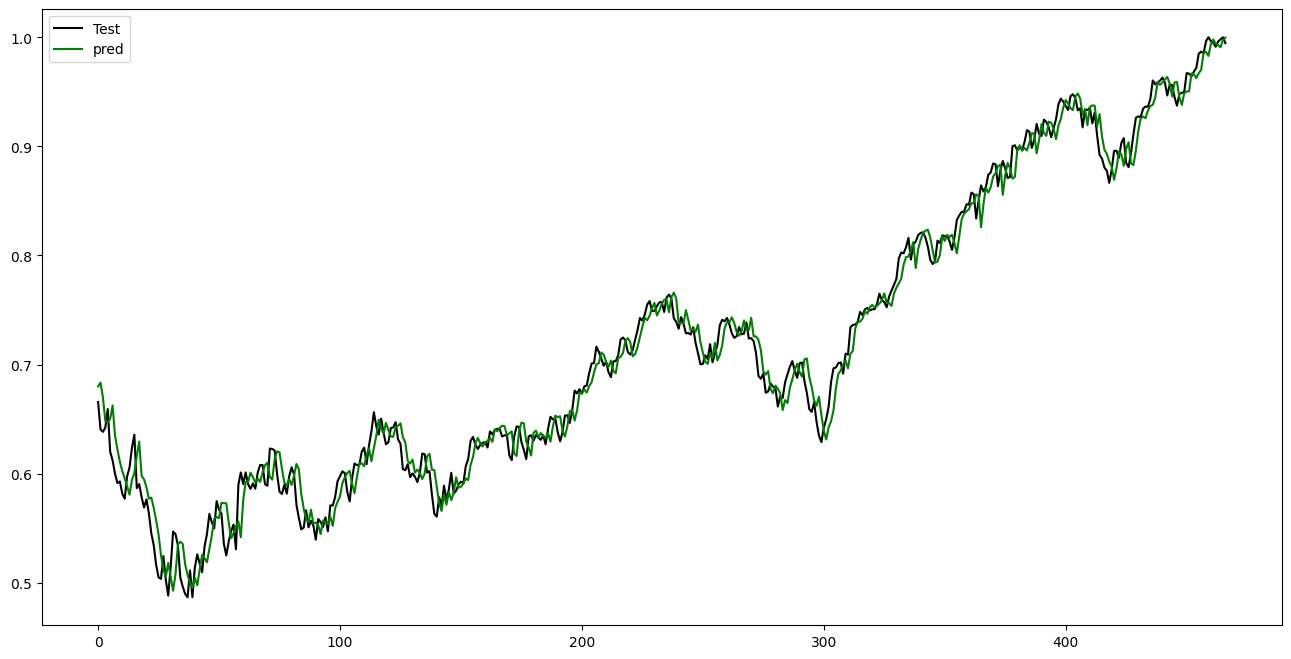

In [18]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color= 'green', label = 'pred')
plt.legend()
plt.show()